In [25]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. 处理成分数据

In [28]:
def parse_elements(composition):
    pattern = r"\(([A-Za-z\d.]+)\)([\d.]+)|([A-Z][a-z]*)([\d.]+)?"
    matches = re.findall(pattern, composition)
    elements = {}
    for match in matches:
        if match[0]:  # 如果有括号
            sub_scale_factor = sum(float(x[1]) if x[1] else 1 for x in re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0]))
            scale_factor = float(match[1]) / sub_scale_factor
            sub_matches = re.findall(r"([A-Z][a-z]*)([\d.]+)?", match[0])
            for sub_match in sub_matches:
                if sub_match[0] not in elements:
                    elements[sub_match[0]] = float(sub_match[1]) * scale_factor if sub_match[1] else scale_factor
        elif match[2]:  # 如果没有括号
            if match[2] not in elements:
                elements[match[2]] = float(match[3]) if match[3] else 1
    sorted_elements = {key: value for key, value in sorted(elements.items(), key=lambda item: item[1], reverse=True)}
    element_strings = [f"{element}{round(value,2)}" for element, value in sorted_elements.items()]
    chem = "".join(element_strings)
    return elements, chem

def check_sum(elements):
    total = sum(elements.values())
    return round(total, 2)

# 使用parse_elements和check_sum函数解析和检查成分
def parse_and_check(composition):
    elements, chem = parse_elements(composition)
    is_sum_100 = check_sum(elements)
    return elements, chem, abs(is_sum_100 - 100) < 0.1

In [29]:
data_o = pd.read_excel("./first_process/data_o.xlsx")
record_chem = {}
for index, row in data_o.iterrows():
    composition = row["Chemical compostion（at.%）"]
    if composition in record_chem:
        print(record_chem[composition], index, composition)
    else:
        record_chem[composition] = index
    elements, chem, is_sum_100 = parse_and_check(composition)

    if not is_sum_100:
        print(f"index {index} sum {is_sum_100}:\n{row}\n")
    data_o.loc[index, "Chemical compostion"] =chem
    # 将新的成分列添加到DataFrame中
    for element, value in elements.items():
        if element not in data_o.columns:
            data_o[element] = 0
        data_o.loc[index, element] = value

In [30]:
data_o.to_excel('./first_process/data_processed.xlsx', index=False)
data_o.describe().to_excel('./first_process/data_processed_describe.xlsx')

# 2. 绘制数据分析图

In [6]:
# 设置箱线图样式
boxprops = dict(linestyle='-', linewidth=2, color='black')
whiskerprops = dict(linestyle='--', linewidth=1.5, color='gray')
flierprops = dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.7)
medianprops = dict(linestyle='-', linewidth=2, color='blue')

def draw_box(data, target_name):
    plt.cla()
    data_d = [data]

    # 设置每组数据对应的标签
    labels = [target_name]

    # 绘制箱线图
    plt.boxplot(data_d, vert=False, showmeans=True, meanline=True,
                boxprops=boxprops, whiskerprops=whiskerprops, flierprops=flierprops, medianprops=medianprops, labels=labels)

    # 添加标题和标签
    plt.title(f'{target_name} Target Distributions(Filter)')
    plt.xlabel('Range')

    # 显示图形
    plt.savefig(f'./first_process/{target_name}_box.png', dpi=300)

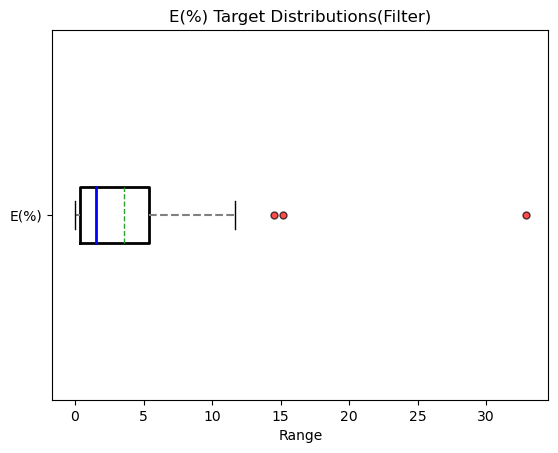

In [12]:
data = pd.read_excel("./first_process/data_processed.xlsx")
target_names = ['Critical Diameter/thickness(mm)', 'Tg(K)', 'Tx(K)' , 'Tl(K)', 'σy(MPa)', 'Modulus (GPa)', 'Ε(%)']
for target in target_names:
    non_empty_values = data.dropna(subset=[target])[target]
    draw_box(non_empty_values, target.replace('/', '_'))

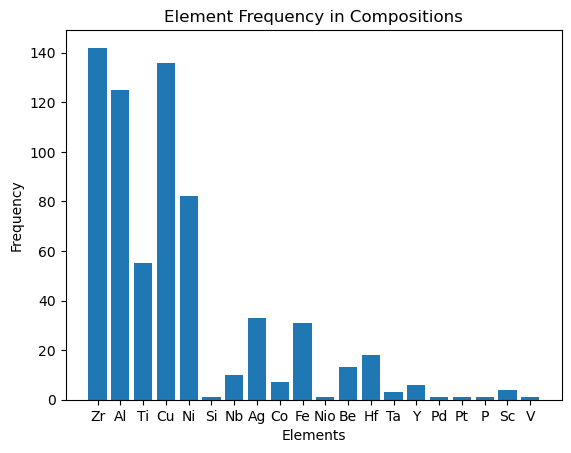

In [17]:
data_f = data.drop(target_names, axis=1, inplace=False)
data_f = data_f.drop(['Chemical compostion（at.%）', "Chemical compostion"], axis=1, inplace=False)
element_count = (data_f != 0).sum()
fig, ax = plt.subplots()
ax.bar(element_count.index, element_count.values)
ax.set_xlabel("Elements")
ax.set_ylabel("Frequency")
ax.set_title("Element Frequency in Compositions")
plt.savefig(f'./first_process/element_statis.png', dpi=300)

In [24]:
properties = ['Critical Diameter/thickness(mm)', 'Tg(K)', 'Tx(K)' , 'Tl(K)', 'σy(MPa)', 'Modulus (GPa)', 'Ε(%)']

for prop in properties:
    fig, ax = plt.subplots()
    non_empty_values = data.dropna(subset=[prop])[prop]
    ax.hist(non_empty_values, bins=10, alpha=0.7)
    ax.set_title(f"{prop} Distribution")
    ax.set_xlabel(prop)
    ax.set_ylabel("Frequency")
    prop = prop.replace('/', '_')
    # 保存每个子图为单独的图片
    plt.savefig(f"./first_process/{prop}_distribution.png")
    plt.close(fig)